# EEE539 Final course project - FNN \& CNN

In [112]:
import sys
import os
import torch
import numpy as np
import pandas as pd
import copy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from  sklearn.datasets import load_breast_cancer
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision.datasets import FashionMNIST
from sklearn.metrics import f1_score, precision_score, recall_score

In [113]:
if torch.cuda.is_available():
	device='cuda:0'
elif torch.backends.mps.is_available():
	device='mps'
else:
	device='cpu'

In [114]:
def process_continuous (data, mean, std):
    return (data-mean)/std

def process_categorical(data, mapping, mal=True):
    if mal:
        try:
            return mapping.index(data)+1
        except ValueError:
            return 0
    else:
        try:
            return mapping.index(data)
        except ValueError:
            print(data)
            print('need special care here')
            return -1

def onehot(x, m, mal=True):
    # +1 for invalid value
    if mal:
        onehot = np.zeros(m+1)
    else:
        onehot = np.zeros(m)
    onehot[x] = 1
    return onehot.astype(int).tolist()

def toidx(y):
    return np.argmax(y, axis=1)

def test(model, ld):
    acc = 0
    with torch.no_grad():
        for xb, yb in ld:
            _, pred = torch.max(model(xb), axis=1)
            acc += torch.eq(pred, torch.max(yb.data, 1)[1]).sum().item()
        acc /= len(ld.dataset)
    return acc

def infer(model, ld):
    with torch.no_grad():
        pred_list = []
        for xb, yb in ld:
            _, pred = torch.max(model(xb), axis=1)
            pred_list.append(pred.cpu().clone().detach().numpy().tolist())
    return np.array(pred_list).flatten()

def plot_converge(epochs, data, label):
    clrs = sns.color_palette("husl",len(data))
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(10,5))
        for i,(k,v) in enumerate(data.items()):
            mean = np.mean(v, axis=0)
            std = np.std(v, axis=0)
            plt.plot(np.arange(epochs), mean, label=k, c=clrs[i])
            plt.fill_between(np.arange(epochs), mean-std, mean+std ,alpha=0.3, facecolor=clrs[i])
        plt.xlabel('Iterations')
        plt.ylabel(label)
        plt.legend()
        plt.show()

In [115]:
# Design Neural Network
class Vanilla_NN(nn.Module):
	def __init__(self, c_in, c_out, layer, activation):
		super().__init__()
		layer = [c_in] + layer + [c_out]
		self.layers = nn.ModuleList()
		self.activation = activation
		for i in range(len(layer) - 1):
			self.layers.append(nn.Linear(layer[i], layer[i+1]))
			

	def forward(self, x):
		for layer in self.layers[:-1]:
			x = self.activation(layer(x))
		out = torch.softmax(self.layers[-1](x), axis=1)
		return out

class Vanilla_CNN(nn.Module):
    def __init__(self, c_in, c_out, channel):
        super().__init__()
        channel = [c_in] + channel
        self.layers = nn.ModuleList()
        for i in range(len(channel) - 1):
            self.layers.append(nn.Conv2d(channel[i], channel[i+1], kernel_size=3, stride=1, padding=1))
            self.layers.append(nn.BatchNorm2d(channel[i+1]))
        self.layers.append(nn.Linear(channel[i+1] * 28 * 28, 1024))
        self.layers.append(nn.Linear(1024, c_out))

    def forward(self, x):
        for layer in self.layers[:-2]:
            if type(layer) in [torch.nn.modules.batchnorm]:
                x = torch.relu(layer(x))
            else:
                x = layer(x)
        x = x.view(x.size(0), -1)
        for layer in self.layers[-2:-1]:
            x = torch.relu(layer(x))
        out = torch.softmax(self.layers[-1](x), axis=1)
        return out

# UCI data with FNN

In [116]:
!pip install ucimlrepo

38446.11s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [117]:
from ucimlrepo import fetch_ucirepo

In [118]:
# Read dataset
adult = fetch_ucirepo(id=2)
X = adult.data.features
Y = adult.data.targets

mapping = {
	'workclass': ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', \
			   'Local-gov', 'State-gov', 'Without-pay', 'Never-worked'],
	'education': ['Bachelors', 'Some-college', '11th', 'HS-grad', 'Prof-school', \
			   'Assoc-acdm', 'Assoc-voc', '9th', '7th-8th', '12th', 'Masters', \
			   '1st-4th', '10th', 'Doctorate', '5th-6th', 'Preschool'],
	'marital-status': ['Married-civ-spouse', 'Divorced', 'Never-married', \
					'Separated', 'Widowed', 'Married-spouse-absent', \
					'Married-AF-spouse'],
	'occupation': ['Tech-support', 'Craft-repair', 'Other-service', 'Sales', \
				'Exec-managerial', 'Prof-specialty', 'Handlers-cleaners', \
				'Machine-op-inspct', 'Adm-clerical', 'Farming-fishing', \
				'Transport-moving', 'Priv-house-serv', 'Protective-serv', \
				'Armed-Forces'],
	'relationship': ['Wife', 'Own-child', 'Husband', 'Not-in-family', \
				  'Other-relative', 'Unmarried'],
	'race': ['White', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other', 'Black'],
	'sex': ['Female', 'Male'],
	'native-country': ['United-States', 'Cambodia', 'England', 'Puerto-Rico',\
					'Canada', 'Germany', 'Outlying-US(Guam-USVI-etc)', 'India',\
					 'Japan', 'Greece', 'South', 'China', 'Cuba', 'Iran', 'Honduras',\
					  'Philippines', 'Italy', 'Poland', 'Jamaica', 'Vietnam', 'Mexico',\
					   'Portugal', 'Ireland', 'France', 'Dominican-Republic', 'Laos', \
					   'Ecuador', 'Taiwan', 'Haiti', 'Columbia', 'Hungary', 'Guatemala',\
					    'Nicaragua', 'Scotland', 'Thailand', 'Yugoslavia', 'El-Salvador',\
						 'Trinadad&Tobago', 'Peru', 'Hong', 'Holand-Netherlands']
}
new_df = []
# Preprocess dataset
data_type = ['c','o','c','o', 'c', 'o', 'o', 'o', 'o', 'o', 'c', 'c', 'c', 'o']
assert(len(data_type) == len(X.columns)),'wrong mapping'
for c, t in zip(X.columns, data_type):
	if t == 'c':
		data = X[[c]]
		mean = np.mean(data.to_numpy())
		std = np.std(data.to_numpy())
		data = data.applymap(lambda x: process_continuous(x, mean, std))
		new_df.append(copy.deepcopy(data))
	elif t == 'o':
		data = X[[c]]
		data = data.applymap(lambda x: process_categorical(x, mapping[c]))
		print(f'invalid representation: {np.sum(data.eq(0)).item()} out of {len(data)}')
		data = data.applymap(lambda x: onehot(x, len(mapping[c])))
		data = pd.DataFrame(np.array(data.values.tolist()).squeeze())
		new_df.append(copy.deepcopy(data))
	else:
		raise KeyError('Not supported tag')
X_processed = pd.concat(new_df, axis=1)
Y_mapping = ['<=50K','<=50K.','>50K','>50K.']
_Y = Y.applymap(lambda x: process_categorical(x, Y_mapping, mal=False))
_Y = _Y['income'].apply(lambda x: int(x/2)).to_frame()
_Y = _Y.applymap(lambda x: onehot(x, 2, mal=False))
Y_processed = pd.DataFrame(np.array(_Y.values.tolist()).squeeze())
X_ = X_processed.to_numpy()
Y_ = Y_processed.to_numpy()
print(X_.shape)
print(Y_.shape)
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.3)

invalid representation: 2799 out of 48842
invalid representation: 0 out of 48842
invalid representation: 0 out of 48842
invalid representation: 2809 out of 48842
invalid representation: 0 out of 48842
invalid representation: 0 out of 48842
invalid representation: 0 out of 48842
invalid representation: 857 out of 48842
(48842, 113)
(48842, 2)


In [ ]:
param1 = {
	'optimizer': optim.SGD,
	'layer': [256],
	'activation': torch.tanh,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param2 = {
	'optimizer': optim.SGD,
	'layer': [256, 512],
	'activation': torch.tanh,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-3
	}
param3 = {
	'optimizer': optim.SGD,
	'layer': [256, 512, 1024],
	'activation': torch.tanh,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-3
	}

params = [param1, param2, param3]

/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

acc @0 is : 0.6974261479964902
Best accuracy is: 0.7380058691053026
================Fold 0===================
acc @0 is : 0.5703422053231939
Best accuracy is: 0.6728997474919811
================Fold 1===================
acc @0 is : 0.42366188944135713
Best accuracy is: 0.5334061284378625
================Fold 2===================
acc @0 is : 0.45539631471190406
Best accuracy is: 0.5707363679792534
================Fold 3===================
acc @0 is : 0.37355565306420946
Best accuracy is: 0.5008530676312019
================Fold 4===================
The test accuracy is: 0.7380058691053026
acc @0 is : 0.7775665399239544
Best accuracy is: 0.8246775404354058
================Fold 0===================
acc @0 is : 0.7954080140391927
Best accuracy is: 0.8246092950249095
================Fold 1===================
acc @0 is : 0.7880959344837671
Best accuracy is: 0.8280215655497167
================Fold 2===================
acc @0 is : 0.7826849956127523
Best accuracy is: 0.8251552583088787
========

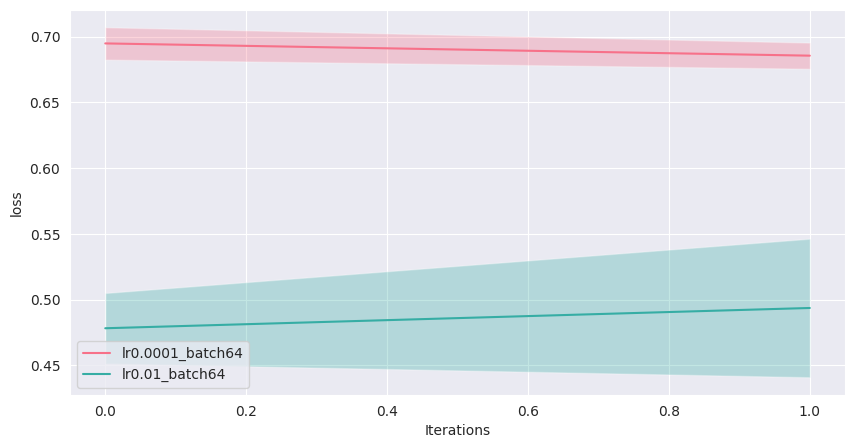

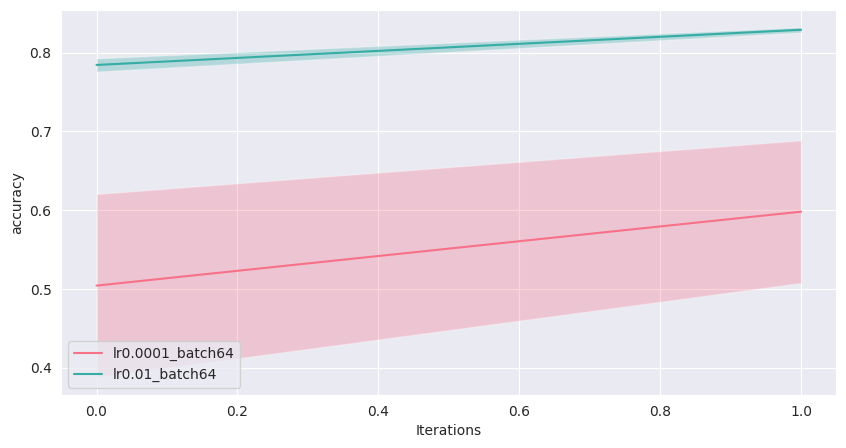

In [121]:
if not os.path.exists('./UCI'):
    os.makedirs('./UCI')
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test) 
Kfold = KFold(n_splits=5, shuffle=True)
loss_dict_train = dict()
acc_dict_val = dict()
for param in params:
    epochs = int(param['epochs'])
    loss_list_train = []
    acc_list_val = []
    performance = []
    test_dl = DataLoader(test_ds, batch_size=param['bs'])
    for fold, (train_ids, val_ids) in enumerate(Kfold.split(train_ds)):
        model = param['network'](X_.shape[1], Y_.shape[1], param['layer'], param['activation']).to(device=device)
        loss_func = nn.CrossEntropyLoss()
        opt = param['optimizer'](model.parameters(), lr=param['lr'])
        scheduler = ExponentialLR(opt, gamma=0.9)
        save_path = f'./UCI/model_fold_{fold}.pth'
        train_subsampler= SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)
        train_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=train_subsampler)
        val_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=val_subsampler)
        best_acc = -1
        loss_list_train_k = []
        acc_list_val_k = []
    
        
        for epoch in range(epochs):
            current_loss = 0
            for xb, yb in train_dl:
                opt.zero_grad()
                pred = model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                opt.step()
                current_loss += loss.item()
            loss_list_train_k.append(loss.cpu().detach().clone().numpy())
            with torch.no_grad():
                correct = 0
                for xb, yb in val_dl:
                    pred = model(xb)
                    _, prediction = torch.max(pred.data,1)
                    correct += torch.eq(prediction, torch.max(yb.data, 1)[1]).sum().item()
                acc = correct/len(val_dl.sampler)
                acc_list_val_k.append(acc)
                if epoch%100 == 0:
                    print(f'acc @{epoch} is : {acc}')
                if acc > best_acc:
                    torch.save(model.state_dict(), save_path)
                    best_acc = acc
        performance.append(best_acc)
        model.load_state_dict(torch.load(save_path))
        loss_list_train.append(loss_list_train_k)
        acc_list_val.append(acc_list_val_k)
        print(f'Best accuracy is: {test(model, test_dl)}')
        print(f'================Fold {fold}===================')
    loss_dict_train.update({f"lr{param['lr']}_batch{param['bs']}": np.array(loss_list_train)})
    acc_dict_val.update({f"lr{param['lr']}_batch{param['bs']}": np.array(acc_list_val)})
    _idx = np.argmax(np.array(performance))
    best_model = param['network'](X_.shape[1], Y_.shape[1], param['layer'], param['activation']).to(device=device)
    best_model.load_state_dict(torch.load(f'./UCI/model_fold_{_idx}.pth'))
    print(f'The test accuracy is: {test(best_model, test_dl)}')
plot_converge(epochs, loss_dict_train, 'loss')
plot_converge(epochs, acc_dict_val, 'accuracy')

In [ ]:
param1 = {
	'optimizer': optim.SGD,
	'layer': [256, 512],
	'activation': torch.relu,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param2 = {
	'optimizer': optim.SGD,
	'layer': [256, 512],
	'activation': torch.tanh,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param3 = {
	'optimizer': optim.SGD,
	'layer': [256, 512],
	'activation': torch.sigmoid,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param5 = {
	'optimizer': optim.Adam,
	'layer': [256, 512],
	'activation': torch.relu,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param6 = {
	'optimizer': optim.Adam,
	'layer': [256, 512],
	'activation': torch.tanh,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param7 = {
	'optimizer': optim.Adam,
	'layer': [256, 512],
	'activation': torch.sigmoid,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}

params = [param1, param2, param3, param5, param6, param7]

/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

acc @0 is : 0.759725065808716
acc @100 is : 0.7568002339865457
Best accuracy is: 0.7654405241247526
================Fold 0===================
acc @0 is : 0.6681778297747879
acc @100 is : 0.765428487861948
Best accuracy is: 0.7612775540844878
================Fold 1===================
acc @0 is : 0.6392219947353027
acc @100 is : 0.7598713073998246
Best accuracy is: 0.7612775540844878
================Fold 2===================
acc @0 is : 0.7563615092132202
acc @100 is : 0.7563615092132202
Best accuracy is: 0.7612775540844878
================Fold 3===================
acc @0 is : 0.700307152259763
acc @100 is : 0.7639315489249671
Best accuracy is: 0.7618917627789531
================Fold 4===================
The test accuracy is: 0.7612775540844878
acc @0 is : 0.765428487861948
acc @100 is : 0.8059374085990055
Best accuracy is: 0.8293182283491435
================Fold 0===================
acc @0 is : 0.7521205030710734
acc @100 is : 0.7984790874524715
Best accuracy is: 0.8282945471917014
====

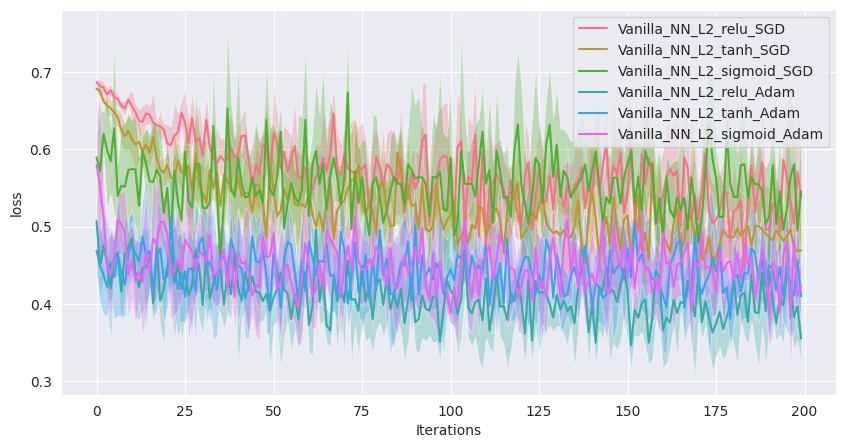

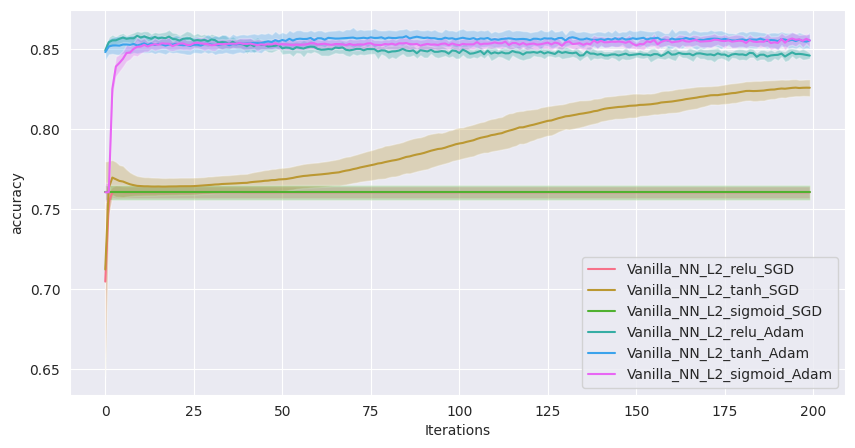

In [71]:
if not os.path.exists('./UCI'):
    os.makedirs('./UCI')
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test) 
Kfold = KFold(n_splits=5, shuffle=True)
loss_dict_train = dict()
acc_dict_val = dict()
for param in params:
    epochs = int(param['epochs'])
    loss_list_train = []
    acc_list_val = []
    performance = []
    test_dl = DataLoader(test_ds, batch_size=param['bs'])
    for fold, (train_ids, val_ids) in enumerate(Kfold.split(train_ds)):
        model = param['network'](X_.shape[1], Y_.shape[1], param['layer'], param['activation']).to(device=device)
        loss_func = nn.CrossEntropyLoss()
        opt = param['optimizer'](model.parameters(), lr=param['lr'])
        scheduler = ExponentialLR(opt, gamma=0.9)
        save_path = f'./UCI/model_fold_{fold}.pth'
        train_subsampler= SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)
        train_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=train_subsampler)
        val_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=val_subsampler)
        best_acc = -1
        loss_list_train_k = []
        acc_list_val_k = []
    
        
        for epoch in range(epochs):
            current_loss = 0
            for xb, yb in train_dl:
                opt.zero_grad()
                pred = model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                opt.step()
                current_loss += loss.item()
            loss_list_train_k.append(loss.cpu().detach().clone().numpy())
            with torch.no_grad():
                correct = 0
                for xb, yb in val_dl:
                    pred = model(xb)
                    _, prediction = torch.max(pred.data,1)
                    correct += torch.eq(prediction, torch.max(yb.data, 1)[1]).sum().item()
                acc = correct/len(val_dl.sampler)
                acc_list_val_k.append(acc)
                if epoch%100 == 0:
                    print(f'acc @{epoch} is : {acc}')
                if acc > best_acc:
                    torch.save(model.state_dict(), save_path)
                    best_acc = acc
        performance.append(best_acc)
        model.load_state_dict(torch.load(save_path))
        loss_list_train.append(loss_list_train_k)
        acc_list_val.append(acc_list_val_k)
        print(f'Best accuracy is: {test(model, test_dl)}')
        print(f'================Fold {fold}===================')
    loss_dict_train.update({f"{param['network'].__name__}_L{len(param['layer'])}_{param['activation'].__name__}_{param['optimizer'].__name__}": np.array(loss_list_train)})
    acc_dict_val.update({f"{param['network'].__name__}_L{len(param['layer'])}_{param['activation'].__name__}_{param['optimizer'].__name__}": np.array(acc_list_val)})
    _idx = np.argmax(np.array(performance))
    best_model = param['network'](X_.shape[1], Y_.shape[1], param['layer'], param['activation']).to(device=device)
    best_model.load_state_dict(torch.load(f'./UCI/model_fold_{_idx}.pth'))
    print(f'The test accuracy is: {test(best_model, test_dl)}')
plot_converge(epochs, loss_dict_train, 'loss')
plot_converge(epochs, acc_dict_val, 'accuracy')

# Breast Cancer data with FNN

In [122]:
data = load_breast_cancer()
N = data['data'].shape[0]
Y_ = np.zeros((N,2))
Y_[np.arange(N),data['target']]=1
X_ = (data['data']-np.mean(data['data'], axis=0, keepdims=True))/np.std(data['data'], axis=0, keepdims=True)
X_train, X_test, y_train, y_test = train_test_split(X_, Y_, test_size=0.3)

In [ ]:
param1 = {
	'optimizer': optim.SGD,
	'layer': [256],
	'activation': torch.tanh,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param2 = {
	'optimizer': optim.SGD,
	'layer': [256, 512],
	'activation': torch.tanh,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-3
	}
param3 = {
	'optimizer': optim.SGD,
	'layer': [256, 512, 1024],
	'activation': torch.tanh,
	'network': Vanilla_NN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-3
	}

params = [param1, param2, param3]

In [105]:
if not os.path.exists('./BreastCancer'):
    os.makedirs('./BreastCancer')
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test) 
Kfold = KFold(n_splits=5, shuffle=True)
loss_dict_train = dict()
acc_dict_val = dict()
for param in params:
    epochs = int(param['epochs'])
    loss_list_train = []
    acc_list_val = []
    performance = []
    test_dl = DataLoader(test_ds, batch_size=param['bs'])
    for fold, (train_ids, val_ids) in enumerate(Kfold.split(train_ds)):
        model = param['network'](X_.shape[1], Y_.shape[1], param['layer'], param['activation']).to(device=device)
        loss_func = nn.CrossEntropyLoss()
        opt = param['optimizer'](model.parameters(), lr=param['lr'])
        scheduler = ExponentialLR(opt, gamma=0.9)
        save_path = f'./BreastCancer/model_fold_{fold}.pth'
        train_subsampler= SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)
        train_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=train_subsampler)
        val_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=val_subsampler)
        best_acc = -1
        loss_list_train_k = []
        acc_list_val_k = []

        
        for epoch in range(epochs):
            current_loss = 0
            for xb, yb in train_dl:
                opt.zero_grad()
                pred = model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                opt.step()
                current_loss += loss.item()
            loss_list_train_k.append(loss.cpu().detach().clone().numpy())
            with torch.no_grad():
                correct = 0
                for xb, yb in val_dl:
                    pred = model(xb)
                    _, prediction = torch.max(pred.data,1)
                    correct += torch.eq(prediction, torch.max(yb.data, 1)[1]).sum().item()
                acc = correct/len(val_dl.sampler)
                acc_list_val_k.append(acc)
                if epoch%100 == 0:
                    print(f'acc @{epoch} is : {acc}')
                if acc > best_acc:
                    torch.save(model.state_dict(), save_path)
                    best_acc = acc
        performance.append(best_acc)
        model.load_state_dict(torch.load(save_path))
        loss_list_train.append(loss_list_train_k)
        acc_list_val.append(acc_list_val_k)
        print(f'Best accuracy is: {test(model, test_dl)}')
        print(f'================Fold {fold}===================')
    loss_dict_train.update({f"{param['network'].__name__}_L{len(param['layer'])}_{param['activation'].__name__}_{param['optimizer'].__name__}": np.array(loss_list_train)})
    acc_dict_val.update({f"{param['network'].__name__}_L{len(param['layer'])}_{param['activation'].__name__}_{param['optimizer'].__name__}": np.array(acc_list_val)})
    _idx = np.argmax(np.array(performance))
    best_model = param['network'](X_.shape[1], Y_.shape[1], param['layer'], param['activation']).to(device=device)
    best_model.load_state_dict(torch.load(f'./BreastCancer/model_fold_{_idx}.pth'))
    print(f'Accuracy: {test(best_model, test_dl)}')
    print(f'F_score: {f1_score(X_test.numpy().tolist(), infer(best_model, test_dl))}')
    print(f'Recall: {recall_score(X_test.numpy().tolist(), infer(best_model, test_dl))}')
    print(f'Precision: {precision_score(X_test.numpy().tolist(), infer(best_model, test_dl))}')
    
plot_converge(epochs, loss_dict_train, 'loss')
plot_converge(epochs, acc_dict_val, 'accuracy')

(569,)

# Fashion MNIST with CNN

In [125]:
train_set = FashionMNIST("./Fashion_MNIST", download=True)
test_set = FashionMNIST("./Fashion_MNIST", download=True, train=False)
X_train = train_set.data.numpy()
y_train = train_set.targets.numpy()
X_test = test_set.data.numpy()
y_test = test_set.targets.numpy()
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])
X_train = (X_train/255.0)[:, np.newaxis]
X_test = (X_test/255.0)[:, np.newaxis]
X_ = X_train
N = X_train.shape[0]
y_train_ = np.zeros((N,10))
y_train_[np.arange(N),y_train]=1
y_train = y_train_

N = X_test.shape[0]
y_test_ = np.zeros((N,10))
y_test_[np.arange(N),y_test]=1
y_test = y_test_

In [108]:
param1 = {
	'optimizer': optim.SGD,
	'layer': [32,64],
	'activation': torch.tanh,
	'network': Vanilla_CNN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param2 = {
	'optimizer': optim.SGD,
	'layer': [32],
	'activation': torch.tanh,
	'network': Vanilla_CNN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
param3 = {
	'optimizer': optim.SGD,
	'layer': [32, 64, 128],
	'activation': torch.tanh,
	'network': Vanilla_CNN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
params = [param1, param2, param3]

/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/home/local/ASURITE/hmei7/miniconda3/envs/cuda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourc

acc @0 is : 0.51605
acc @10 is : 0.76255
acc @20 is : 0.783
acc @30 is : 0.79205
acc @40 is : 0.79825
acc @50 is : 0.82355
acc @60 is : 0.8289
acc @70 is : 0.83315
acc @80 is : 0.83555
acc @90 is : 0.8396
acc @100 is : 0.8424
acc @110 is : 0.844
acc @120 is : 0.84555
acc @130 is : 0.84765
acc @140 is : 0.8476
acc @150 is : 0.8497
acc @160 is : 0.8506
acc @170 is : 0.8523
acc @180 is : 0.8532
acc @190 is : 0.85445
Best accuracy is: 0.8452
================Fold 0===================
acc @0 is : 0.50795
acc @10 is : 0.76725
acc @20 is : 0.786
acc @30 is : 0.8212
acc @40 is : 0.8295
acc @50 is : 0.83605
acc @60 is : 0.8394
acc @70 is : 0.84275
acc @80 is : 0.8452
acc @90 is : 0.8479
acc @100 is : 0.8496
acc @110 is : 0.852
acc @120 is : 0.85355
acc @130 is : 0.85455
acc @140 is : 0.85585
acc @150 is : 0.856
acc @160 is : 0.85835
acc @170 is : 0.8577
acc @180 is : 0.85855
acc @190 is : 0.85965
Best accuracy is: 0.8475
================Fold 1===================
acc @0 is : 0.4946
acc @10 is : 0

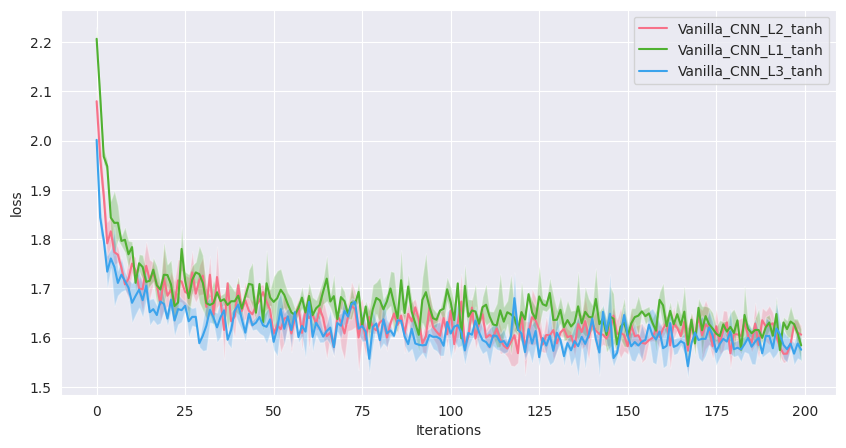

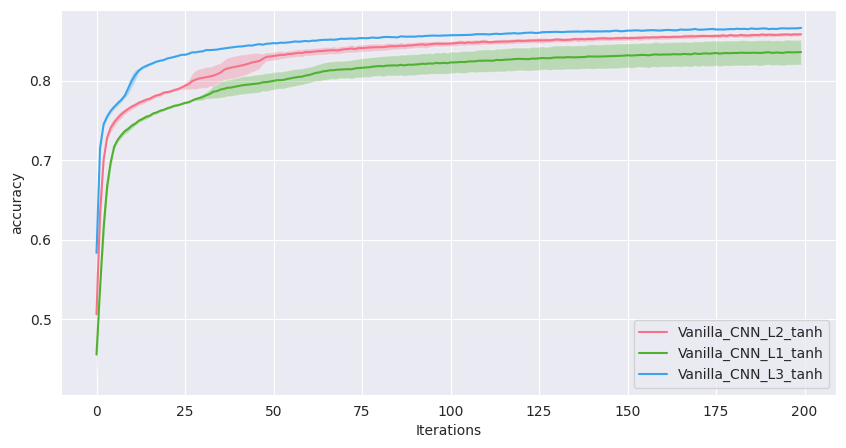

In [111]:
if not os.path.exists('./MNIST'):
    os.makedirs('./MNIST')
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test) 
Kfold = KFold(n_splits=3, shuffle=True)
loss_dict_train = dict()
acc_dict_val = dict()
for param in params:
    loss_list_train = []
    acc_list_val = []
    performance = []
    test_dl = DataLoader(test_ds, batch_size=param['bs'])
    for fold, (train_ids, val_ids) in enumerate(Kfold.split(train_ds)):
        model = param['network'](1, y_train.shape[1], param['layer']).to(device=device)
        loss_func = nn.CrossEntropyLoss()
        opt = param['optimizer'](model.parameters(), lr=param['lr'])
        scheduler = ExponentialLR(opt, gamma=0.9)
        save_path = f'./MNIST/model_fold_{fold}.pth'
        train_subsampler= SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)
        train_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=train_subsampler)
        val_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=val_subsampler)
        best_acc = -1
        loss_list_train_k = []
        acc_list_val_k = []
        epochs = int(param['epochs'])
        for epoch in range(epochs):
            current_loss = 0
            for xb, yb in train_dl:
                opt.zero_grad()
                pred = model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                opt.step()
                current_loss += loss.item()
            loss_list_train_k.append(loss.cpu().detach().clone().numpy())
            with torch.no_grad():
                correct = 0
                for xb, yb in val_dl:
                    pred = model(xb)
                    _, prediction = torch.max(pred.data,1)
                    correct += torch.eq(prediction, torch.max(yb.data, 1)[1]).sum().item()
                acc = correct/len(val_dl.sampler)
                acc_list_val_k.append(acc)
                if epoch%10 == 0:
                    print(f'acc @{epoch} is : {acc}')
                if acc > best_acc:
                    torch.save(model.state_dict(), save_path)
                    best_acc = acc
        performance.append(best_acc)
        model.load_state_dict(torch.load(save_path))
        loss_list_train.append(loss_list_train_k)
        acc_list_val.append(acc_list_val_k)
        print(f'Best accuracy is: {test(model, test_dl)}')
        print(f'================Fold {fold}===================')
    loss_dict_train.update({f"{param['network'].__name__}_L{len(param['layer'])}_{param['activation'].__name__}": np.array(loss_list_train)})
    acc_dict_val.update({f"{param['network'].__name__}_L{len(param['layer'])}_{param['activation'].__name__}": np.array(acc_list_val)})
    _idx = np.argmax(np.array(performance))
    best_model =  param['network'](1, y_train.shape[1], param['layer']).to(device=device)
    best_model.load_state_dict(torch.load(f'./MNIST/model_fold_{_idx}.pth'))
print(f'The test accuracy is: {test(best_model, test_dl)}')
plot_converge(epochs, loss_dict_train, 'loss')
plot_converge(epochs, acc_dict_val, 'accuracy')

In [126]:
param1 = {
	'optimizer': optim.Adam,
	'layer': [32, 64, 128],
	'activation': torch.tanh,
	'network': Vanilla_CNN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-3
	}
param2 = {
	'optimizer': optim.Adam,
	'layer': [32, 64, 128],
	'activation': torch.tanh,
	'network': Vanilla_CNN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-2
	}
param3 = {
	'optimizer': optim.Adam,
	'layer': [32, 64, 128],
	'activation': torch.tanh,
	'network': Vanilla_CNN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-4
	}
param4 = {
	'optimizer': optim.Adam,
	'layer': [32, 64, 128],
	'activation': torch.tanh,
	'network': Vanilla_CNN,
	'epochs' : 200, 
	'bs':64,
	'lr': 10e-5
	}
params = [param1, param2, param3, param4]

In [127]:
if not os.path.exists('./MNIST'):
    os.makedirs('./MNIST')
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test = torch.tensor(y_test, dtype=torch.float32, device=device)
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test) 
Kfold = KFold(n_splits=3, shuffle=True)
loss_dict_train = dict()
acc_dict_val = dict()
for param in params:
    loss_list_train = []
    acc_list_val = []
    performance = []
    test_dl = DataLoader(test_ds, batch_size=param['bs'])
    for fold, (train_ids, val_ids) in enumerate(Kfold.split(train_ds)):
        model = param['network'](1, y_train.shape[1], param['layer']).to(device=device)
        loss_func = nn.CrossEntropyLoss()
        opt = param['optimizer'](model.parameters(), lr=param['lr'])
        scheduler = ExponentialLR(opt, gamma=0.9)
        save_path = f'./MNIST/model_fold_{fold}.pth'
        train_subsampler= SubsetRandomSampler(train_ids)
        val_subsampler = SubsetRandomSampler(val_ids)
        train_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=train_subsampler)
        val_dl = DataLoader(train_ds, batch_size=param['bs'], sampler=val_subsampler)
        best_acc = -1
        loss_list_train_k = []
        acc_list_val_k = []
        epochs = int(param['epochs'])
        for epoch in range(epochs):
            current_loss = 0
            for xb, yb in train_dl:
                opt.zero_grad()
                pred = model(xb)
                loss = loss_func(pred, yb)
                loss.backward()
                opt.step()
                current_loss += loss.item()
            loss_list_train_k.append(loss.cpu().detach().clone().numpy())
            with torch.no_grad():
                correct = 0
                for xb, yb in val_dl:
                    pred = model(xb)
                    _, prediction = torch.max(pred.data,1)
                    correct += torch.eq(prediction, torch.max(yb.data, 1)[1]).sum().item()
                acc = correct/len(val_dl.sampler)
                acc_list_val_k.append(acc)
                if epoch%20 == 0:
                    print(f'acc @{epoch} is : {acc}')
                if acc > best_acc:
                    torch.save(model.state_dict(), save_path)
                    best_acc = acc
        performance.append(best_acc)
        model.load_state_dict(torch.load(save_path))
        loss_list_train.append(loss_list_train_k)
        acc_list_val.append(acc_list_val_k)
        print(f'Best accuracy is: {test(model, test_dl)}')
        print(f'================Fold {fold}===================')
    loss_dict_train.update({f"lr{param['lr']}_bs{param['bs']}": np.array(loss_list_train)})
    acc_dict_val.update({f"lr{param['lr']}_bs{param['bs']}": np.array(acc_list_val)})
    _idx = np.argmax(np.array(performance))
    best_model =  param['network'](1, y_train.shape[1], param['layer']).to(device=device)
    best_model.load_state_dict(torch.load(f'./MNIST/model_fold_{_idx}.pth'))
print(f'The test accuracy is: {test(best_model, test_dl)}')
plot_converge(epochs, loss_dict_train, 'loss')
plot_converge(epochs, acc_dict_val, 'accuracy')

acc @0 is : 0.09795
